# Feature Engineering and Selection

This notebook has two objectives:
1. To study and plot the correlations of the features that will be shown in the dashboard
2. To create the dataframe that will train our model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

From the previous analysis, we know that gas consumption and gas stocks are periodic and well autocorrelated, and as such we can employ an autoregression model to forecast their values from 2022 to today. As we will se in the following section, we can perform a gas volume balance to get something similar to gas imports.

In [127]:
dfIT.loc['2014-01-01','ratio']

0.6560946745562131

### Feature engineering and selection

Analyzing feature: ratio


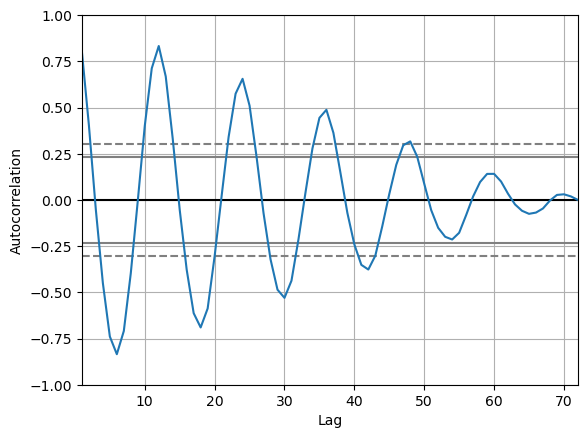

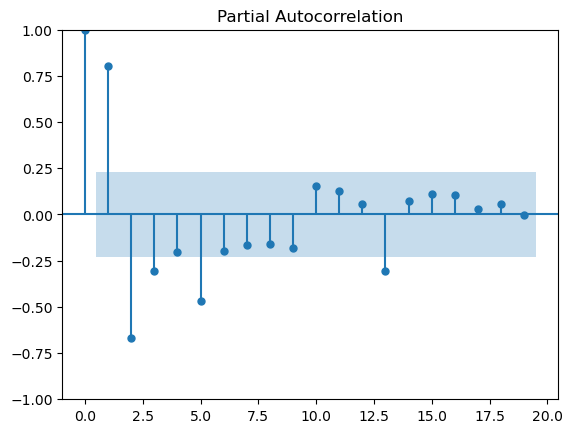

In [99]:
dfIT = pd.read_csv('Data_03.csv')
dfIT=dfIT.set_index('date')
dfIT.index=pd.to_datetime(dfIT.index, format='%Y-%m-%d')

#The idea behind the next feature is: 'ratio' looks periodic, if it can be autocorrelated, then we have a good candidate for the forecasting!
dfIT['ratio'] = dfIT['Gas imported Mm3']/dfIT['Gas consumed Mm3']

from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

plotter = dfIT.loc[(dfIT.loc[:,'ratio'].notna()) & (dfIT.index < '2020-01-01'),'ratio']
print('Analyzing feature: ' + plotter.name)

#autocorrelation 
autocorrelation_plot(plotter)
plt.show()

#Partial autocorrelation
plot_pacf(plotter)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   74
Model:             Restr. AutoReg(36)   Log Likelihood                  70.391
Method:               Conditional MLE   S.D. of innovations              0.038
Date:                Tue, 07 May 2024   AIC                           -126.782
Time:                        13:53:49   BIC                           -115.319
Sample:                            36   HQIC                          -122.704
                                   74                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0617      0.026      2.338      0.019       0.010       0.113
y.L1           0.0515      0.090      0.569      0.569      -0.126       0.229
y.L2          -0.1068      0.054     -1.985      0.0

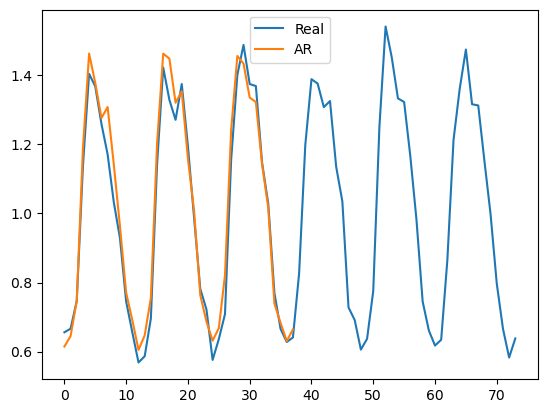

In [104]:
#Testing on itself
Y=dfIT.values[:,10]

split_point = round(len(Y)*0.75)
train, test = Y[0:split_point], Y[split_point:]

# train autoregression
model = AutoReg(train, lags=[1,2,12,24,36], missing='drop')
model_fit = model.fit()

print(model_fit.summary())
plt.plot(train[~np.isnan(train)],label='Real')
plt.plot(model_fit.fittedvalues,label='AR')
plt.legend()

Let's try an analytical formulation for 'ratio', using sine waves to approximate it

Hi Nicola, this is for you after lunch: do the analytical/numerical approximation, do the autoregression for consumption, gas stocks, gas generated (?), and sborr. then do feature selection, then the forecast and sborr even more. See if columns last month have any significance.

In [149]:
#Searching manually for appropriate indexes from 01-01-2014 to 02-02-2020
print(dfIT.loc[pd.to_datetime('2014-01-01',format='%Y-%m-%d'),'ratio'])
dfIT = dfIT.reset_index()
print(dfIT.values[72:146,11])
dfIT = dfIT.set_index('date')
print(dfIT.loc[pd.to_datetime('2020-02-01',format='%Y-%m-%d'),'ratio'])

0.6560946745562131
[0.6560946745562131 0.6664751508187302 0.7463791968400263
 1.1363085132185302 1.403494623655914 1.3670286828181566 1.258554154875225
 1.1704582921200133 1.0320388349514562 0.92771608970172 0.744814362907443
 0.6556430446194226 0.5687578850785641 0.5867952522255193
 0.6959401094154909 1.1401031158932975 1.4216508795669824
 1.3280088129991738 1.2704900021973193 1.3739698778061948
 1.1940406976744187 0.9861627426683188 0.7816091954022989
 0.7220572514550422 0.5761060008760402 0.6364120308756986
 0.708511243951039 1.15578231292517 1.4004790419161677 1.4870828848223896
 1.3738964447625865 1.368080921607193 1.1473684210526316 1.028393966282165
 0.7700656572423958 0.6658190294553931 0.6280405708643748
 0.6410002475860361 0.8263749807425667 1.1975180972078594
 1.3880266075388026 1.375172097292336 1.3071193866374589
 1.3247734138972809 1.1347353824820892 1.0345617720068743
 0.7277427490542244 0.6915310117453122 0.6059610154125114
 0.6370015593673424 0.7752604797673855 1.25021

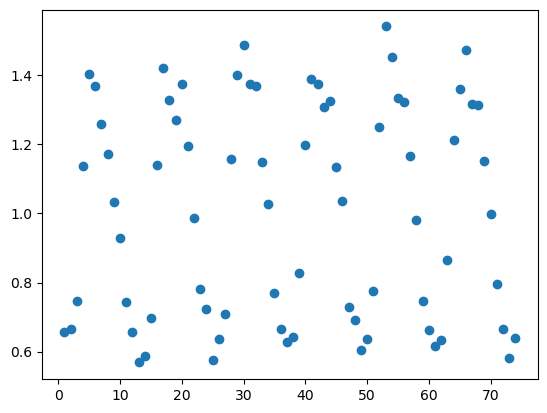

Amplitude=0.42, Angular freq.=0.52, phase=-1.92, offset=1.02, Max. Cov.=0.004910


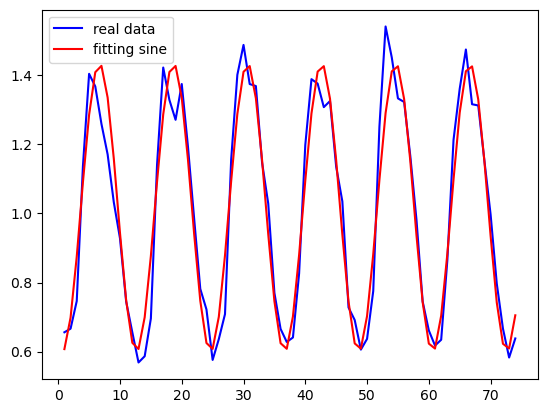

In [192]:
import numpy as np
import scipy.optimize

yy = dfIT.values[72:146,10]
tt = np.arange(1,len(yy)+1,1)

plt.scatter(tt, yy)
plt.show()

def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # Assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # Exclude the zero frequency peak related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.0 * np.pi * guess_freq, 0.0, guess_offset])

    def sinfunc(t, A, w, p, c):
        return A * np.sin(w * t + p) + c

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    fitfunc = lambda t: A * np.sin(w * t + p) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": 1.0 / f,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov)
    }

# Example usage:
#N = 500
#amp, omega, phase, offset, noise = 1.0, 2.0, 0.5, 4.0, 3.0

res = fit_sin(tt, yy)
print(f"Amplitude={res['amp']:.2f}, Angular freq.={res['omega']:.2f}, phase={res['phase']:.2f}, offset={res['offset']:.2f}, Max. Cov.={res['maxcov']:.6f}")

yy1 = sinfunc(tt, res['amp'], res['omega'], res['phase'], res['offset'])
plt.plot(tt, yy, "-b", label="real data")
plt.plot(tt, yy1, "-r", label="fitting sine")
plt.legend(loc="upper left")
plt.show()

dfIT['sine_ratio'] = sinfunc(dfIT['Month'], res['amp'], res['omega'], res['phase'], res['offset'])


We will try to use this ratio in the following

,Electricity import (GWh),Electricity generated from natural gas GWh,Total electricity generated GWh,Fraction of electricity generated by gas,Gas imported Mm3,Gas consumed Mm3,Gas exported Mm3,Gas produced Mm3,Total Gas Stocks Mm3,Average Temperature (°C),...,Month,sinMonth,Gas imported last month Mm3,Gas consumed last month Mm3,Gas produced last month Mm3,Total Gas Stocks last month Mm3,Gas consumed from stocks Mm3,Gas escaped Mm3,Net new gas Mm3,sinEstimator
Electricity import (GWh),1.000000,0.133923,0.872657,-0.042355,0.246648,0.020330,-0.026956,0.044613,0.142806,0.185359,...,0.005748,-0.166512,0.097845,-0.171870,-0.032568,0.155066,0.034189,-0.029324,0.255138,0.246648
Electricity generated from natural gas GWh,0.133923,1.000000,-0.023157,0.973269,-0.039155,0.213203,0.337651,-0.222525,0.121843,-0.221044,...,0.052099,0.198910,0.001915,0.064680,-0.231983,0.270044,0.286347,-0.284680,-0.054576,-0.039155
Total electricity generated GWh,0.872657,-0.023157,1.000000,-0.190447,0.337556,0.110240,-0.153263,0.269469,0.233935,0.342456,...,0.093096,-0.300668,0.199523,-0.172886,0.190325,0.222179,-0.022594,0.020312,0.360153,0.337556
Fraction of electricity generated by gas,-0.042355,0.973269,-0.190447,1.000000,-0.118320,0.162103,0.379851,-0.267965,0.117548,-0.235799,...,0.064303,0.229928,-0.038544,0.051606,-0.266479,0.257397,0.270217,-0.267750,-0.148848,-0.118320
Gas imported Mm3,0.246648,-0.039155,0.337556,-0.118320,1.000000,0.243654,0.148908,-0.307448,-0.237925,-0.100329,...,-0.094649,-0.011062,0.580288,0.189331,-0.310413,-0.278044,-0.074559,0.074713,0.941670,1.000000
Gas consumed Mm3,0.020330,0.213203,0.110240,0.162103,0.243654,1.000000,-0.038019,0.044897,-0.298842,-0.838957,...,-0.172957,0.877690,0.048760,0.808250,0.044755,0.135560,0.870914,-0.942080,0.482141,0.243654
Gas exported Mm3,-0.026956,0.337651,-0.153263,0.379851,0.148908,-0.038019,1.000000,-0.547118,0.089028,-0.435195,...,0.144394,0.028599,0.124975,-0.093981,-0.563516,0.098639,0.017701,-0.015584,-0.056702,0.148908
Gas produced Mm3,0.044613,-0.222525,0.269469,-0.267965,-0.307448,0.044897,-0.547118,1.000000,-0.062198,-0.151919,...,0.003026,0.051341,-0.361340,0.014022,0.969137,-0.036563,0.048709,-0.051156,-0.171703,-0.307448
Total Gas Stocks Mm3,0.142806,0.121843,0.233935,0.117548,-0.237925,-0.298842,0.089028,-0.062198,1.000000,0.449599,...,0.717392,-0.356617,-0.185388,-0.654375,-0.099007,0.873098,-0.252721,0.269485,-0.320280,-0.237925
Average Temperature (°C),0.185359,-0.221044,0.342456,-0.235799,-0.100329,-0.838957,-0.435195,-0.151919,0.449599,1.000000,...,0.285692,-0.971748,0.082349,-0.798573,-0.221911,0.045129,-0.839343,0.885293,-0.318333,-0.100329


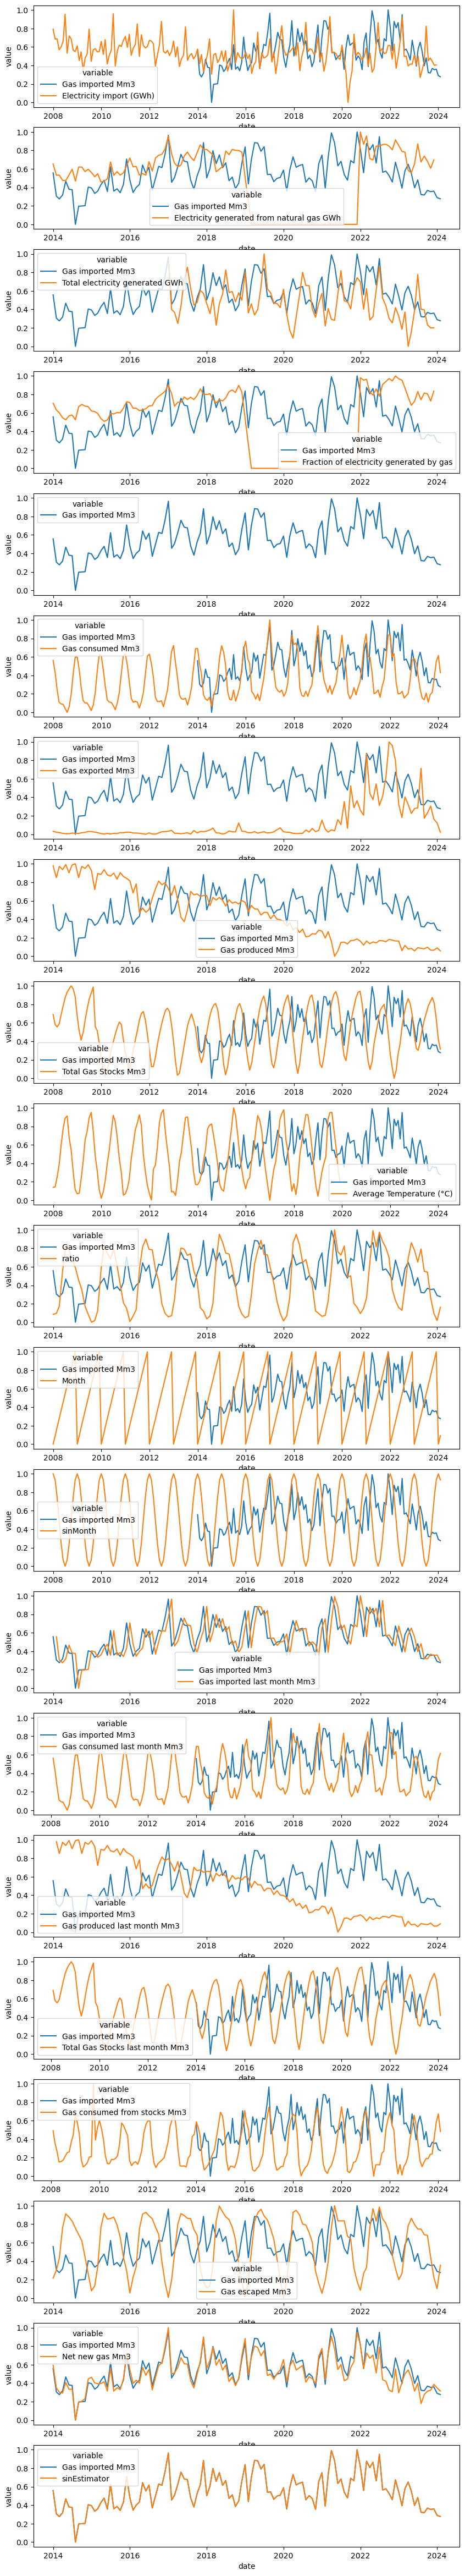

In [191]:
#Extracting features
dfIT['Month'] = dfIT.index.month
dfIT['sinMonth'] = (1 + np.sin((dfIT['Month']+2)/6*np.pi))/2 #January is numerically close to December

#Shifting features
dfIT['Gas imported last month Mm3'] = dfIT['Gas imported Mm3'].shift(1) # Gas imported the last month
dfIT['Gas consumed last month Mm3'] = dfIT['Gas consumed Mm3'].shift(1) # Gas consumed the last month
dfIT['Gas produced last month Mm3'] = dfIT['Gas produced Mm3'].shift(1) # Gas imported the last month
dfIT['Total Gas Stocks last month Mm3'] = dfIT['Total Gas Stocks Mm3'].shift(1) # Gas imported the last month

#Balance features
dfIT['Gas consumed from stocks Mm3'] = dfIT['Total Gas Stocks Mm3'].shift(1) - dfIT['Total Gas Stocks Mm3'] 
dfIT['Gas escaped Mm3'] = dfIT['Gas imported Mm3'] - dfIT['Gas exported Mm3'] + dfIT['Gas produced Mm3'] - dfIT['Gas consumed Mm3'] - dfIT['Gas consumed from stocks Mm3']
dfIT['Net new gas Mm3'] = dfIT['Gas consumed Mm3'] - dfIT['Gas consumed from stocks Mm3'] - dfIT['Gas produced Mm3']

#Let's see 'ratio' in action!
dfIT['sinEstimator'] = dfIT['Gas consumed Mm3']*dfIT['ratio']

#Plotting normalized data
dfITn = dfIT.copy(deep=True)

for column in dfITn.columns: #what I do here is put all values on a scale from 0 to 1, where 0 corresponds to min value and 1 to max value
    dfITn.loc[:,column] = (dfITn.loc[:,column] - dfITn.loc[:,column].min())/(dfITn.loc[:,column].max() - dfITn.loc[:,column].min())

dfITn = dfITn.reset_index()

fig, axes = plt.subplots(len(dfITn.columns)-1,1,figsize = (10,60))

j = 1
for i in range(0,len(dfITn.columns)-1):
    sb.lineplot(x='date', y='value', hue='variable',data = pd.melt(dfITn[['date','Gas imported Mm3',dfITn.columns[j]]], ['date']), ax=axes[i])
    j = j + 1

dfITn = dfITn.set_index('date')

#let's see for only the non-NaN values
display(dfITn.corr())


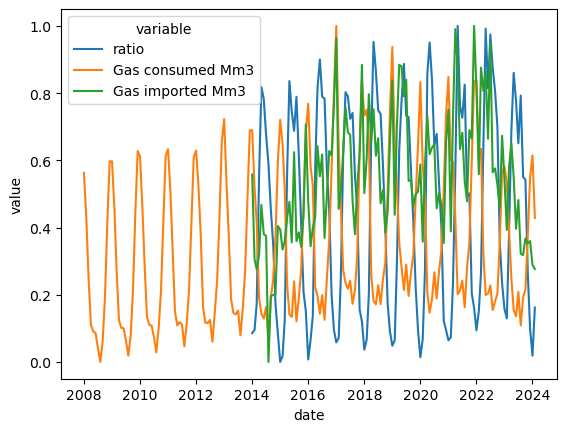

In [93]:
#dfIT.index = dfIT.index.strftime('%Y-%m-%d')

dfITn = dfITn.reset_index()
sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfITn[['date','ratio','Gas consumed Mm3','Gas imported Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfIT[['date','ratio','Gas consumed Mm3','Gas imported Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfIT[['date','Total Gas Stocks Mm3','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfIT[['date','Gas import - Gas export Mm3','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfITn[['date','sinMonth','Gas consumed Mm3']], ['date']))
#sb.lineplot(x='date', y='value', hue='variable', data = pd.melt(dfITn[['date','Gas consumed Mm3','Total Gas Stocks Mm3']], ['date']))

dfITn = dfITn.set_index('date')

In [ ]:
dfITn = dfITn.reset_index()
display(dfITn)
sb.lineplot(x='date', y='value', hue='variable',data = pd.melt(dfITn[['date','Gas imported Mm3',dfITn.columns[j]]], ['date']))
dfITn = dfITn.set_index('date')

,date,Electricity import (GWh),Electricity generated from natural gas GWh,Total electricity generated GWh,Fraction of electricity generated by gas,Gas consumed Mm3,Gas produced Mm3,Gas exported Mm3,Gas imported Mm3,Total Gas Stocks Mm3,Average Temperature (°C),Month,sinMonth,Gas imported last month Mm3,Gas consumed from stocks Mm3,Gas balance (???)
0,2008-01-01,275.0,NaN,NaN,NaN,7349.903293,NaN,NaN,NaN,14536.047619,NaN,1,2.000000,NaN,NaN,NaN
1,2008-02-01,365.0,NaN,NaN,NaN,6187.250915,NaN,NaN,NaN,13159.928571,NaN,2,1.866025,NaN,-1376.119048,NaN
2,2008-03-01,473.0,NaN,NaN,NaN,4644.642362,NaN,NaN,NaN,12846.952381,NaN,3,1.500000,NaN,-312.976190,NaN
3,2008-04-01,185.0,NaN,NaN,NaN,3422.614249,NaN,NaN,NaN,13234.309524,NaN,4,1.000000,NaN,387.357143,NaN
4,2008-05-01,194.0,NaN,NaN,NaN,3259.896578,NaN,NaN,NaN,14483.452381,NaN,5,0.500000,NaN,1249.142857,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2023-10-01,211.0,9532.0,20770.0,0.458931,4335.000000,253.0,162.0,4865.0,16807.542857,NaN,10,1.000000,4687.0,563.335714,57.664286
190,2023-11-01,266.0,8484.0,20469.0,0.414480,5744.000000,240.0,211.0,4814.0,15990.207143,NaN,11,1.500000,4865.0,-817.335714,-83.664286
191,2023-12-01,402.0,9749.0,20483.0,0.475956,7235.000000,240.0,117.0,4836.0,13925.550000,NaN,12,1.866025,4814.0,-2064.657143,-211.342857
192,2024-01-01,NaN,NaN,NaN,NaN,7799.000000,250.0,90.0,4583.0,11153.321429,NaN,1,2.000000,4836.0,-2772.228571,-283.771429


IndexError: index 16 is out of bounds for axis 0 with size 16